First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt
!conda env list


# conda environments:
#
# * -> active
# + -> frozen
base                     /opt/anaconda3
BI2025               *   /opt/anaconda3/envs/BI2025



In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json 
from starvers.starvers import TripleStoreEngine
# import sklearn
from sklearn.preprocessing import StandardScaler

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12434665'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '06'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12127674'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12434665'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Nikola" .',
f':{student_a} foaf:familyName "Lukic" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12127674"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Kerim" .',
f':{student_b} foaf:familyName "Halilovic" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12434665"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## Business Understanding 

In [10]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [11]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The dataset consists of two CSV files (`rome_weekdays.csv` and `rome_weekends.csv`) containing Airbnb listings in Rome. It includes attributes such as price (`realSum`), room type, capacity, cleanliness rating, guest satisfaction, and distance from the city center and metro.

Scenario: A property management firm in Rome wants to optimize their pricing strategy and investment portfolio. They need to understand which factors most significantly drive listing prices (e.g., is being closer to the metro more valuable than a high cleanliness rating?) to predict the optimal price for new properties entering the market.
"""

business_objectives_comment = """
The primary business objective is to maximize revenue for property owners by setting optimal rental prices. This requires identifying the key drivers of listing value in the Rome market (e.g., location vs. amenities) and providing a tool to estimate fair market value for new or existing listings to avoid underpricing or overpricing.
"""

business_success_criteria_comment = """
1. Insight Generation: Identify the top 3 factors that account for at least 50% of the explained variance in listing prices, providing actionable levers for property managers.
2. Pricing Accuracy: The model should predict listing prices with sufficient accuracy to be useful for setting initial rental rates (e.g., within a reasonable error margin relative to the average listing price).
"""

data_mining_goals_comment = """
1. Regression Task: Develop a regression model to predict the `realSum` (total price) of a listing based on its features (distance, room type, satisfaction, etc.).
2. Feature Importance: Analyze the model to determine feature importance coefficients, quantifying the impact of distance, room type, and weekday vs. weekend timing on price.
"""

data_mining_success_criteria_comment = """
1. Model Performance: Achieve an R-squared (R^2) score of at least 0.60 on the test set, indicating that the model explains at least 60% of the variance in pricing.
2. Error Metric: Achieve a Mean Absolute Error (MAE) lower than 40 Euros, ensuring the predicted price is, on average, within a useful range of the actual market price.
"""

ai_risk_aspects_comment = """
1. Bias & Fairness: The dataset might reflect existing gentrification patterns. If location is a strong predictor, the model might undervalue properties in up-and-coming neighborhoods, potentially reinforcing economic disparities.
2. Temporal Validity: The data is a snapshot in time. Prices fluctuate seasonally (e.g., Jubilee year in Rome). A risk exists that the model becomes obsolete if not retraining regularly with current data.
3. Data Quality: "Guest satisfaction" is subjective. Relying heavily on it might introduce noise if ratings are biased or manipulated.
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [12]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
rome_data_path = os.path.join("data")

load_data_code_writer = student_a  # Student A is responsible for Data Understanding

def load_airbnb_data() -> pd.DataFrame:
    ### Load Rome Airbnb data
    wd_file = os.path.join(rome_data_path, 'rome_weekdays.csv')
    we_file = os.path.join(rome_data_path, 'rome_weekends.csv')
    
    df_wd = pd.read_csv(wd_file)
    df_we = pd.read_csv(we_file)
    
    # Add a feature to distinguish them before merging
    df_wd['is_weekend'] = False
    df_we['is_weekend'] = True
    
    # Merge datasets
    full_data = pd.concat([df_wd, df_we], ignore_index=True)
    
    # Clean up the unnamed index column if it exists
    if 'Unnamed: 0' in full_data.columns:
        full_data.drop(columns=['Unnamed: 0'], inplace=True)
        
    return full_data

start_time_ld = now()
data = load_airbnb_data()
end_time_ld = now()

display(data.head())
print(data.info())

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend
0,156.874664,Private room,False,True,2.0,True,1,0,10.0,95.0,1,2.978468,1.595733,281.163932,6.230648,697.727246,15.191486,12.48654,41.92498,False
1,172.772543,Private room,False,True,2.0,False,1,0,9.0,80.0,1,0.935371,0.649269,482.707193,10.696887,1251.524333,27.249208,12.49627,41.90801,False
2,277.745307,Entire home/apt,False,False,4.0,False,0,1,9.0,90.0,1,2.203025,0.494697,691.708998,15.328408,1625.897266,35.400361,12.47700,41.90700,False
3,444.906834,Entire home/apt,False,False,6.0,False,1,0,9.0,92.0,2,2.703010,1.295153,805.592641,17.852092,2035.819533,44.325522,12.46969,41.90019,False
4,131.391298,Private room,False,True,3.0,False,1,0,9.0,91.0,1,1.295968,0.867455,317.076369,7.026475,836.622814,18.215634,12.51544,41.89463,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9027 entries, 0 to 9026
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     9027 non-null   float64
 1   room_type                   9027 non-null   object 
 2   room_shared                 9027 non-null   bool   
 3   room_private                9027 non-null   bool   
 4   person_capacity             9027 non-null   float64
 5   host_is_superhost           9027 non-null   bool   
 6   multi                       9027 non-null   int64  
 7   biz                         9027 non-null   int64  
 8   cleanliness_rating          9027 non-null   float64
 9   guest_satisfaction_overall  9027 non-null   float64
 10  bedrooms                    9027 non-null   int64  
 11  dist                        9027 non-null   float64
 12  metro_dist                  9027 non-null   float64
 13  attr_index                  9027 

In [14]:
attribute_semantics = {
    "realSum": "Target Variable. Total price of the listing for 2 people for 2 nights. Unit: EUR",
    "room_type": "Categorical. The type of accommodation (e.g., 'Private room', 'Entire home/apt').",
    "room_shared": "Boolean. True if the room is shared with others.",
    "room_private": "Boolean. True if the room is private.",
    "person_capacity": "The maximum number of guests allowed. Unit: Count",
    "host_is_superhost": "Boolean. True if the host has 'Superhost' status (high ratings/reliability).",
    "multi": "Binary (0/1). Indicates if the host manages multiple listings (1=Yes).",
    "biz": "Binary (0/1). Indicates if the host is a business/professional entity (1=Yes).",
    "cleanliness_rating": "The cleanliness score given by guests. Unit: Scale (likely 1-10).",
    "guest_satisfaction_overall": "The overall rating score from guest reviews. Unit: Scale (0-100).",
    "bedrooms": "Number of bedrooms in the listing. Unit: Count",
    "dist": "Distance from the city center. Unit: Kilometers",
    "metro_dist": "Distance to the nearest metro station. Unit: Kilometers",
    "attr_index": "Undocumented attribute.",
    "attr_index_norm": "Undocumented attribute.",
    "rest_index": "Undocumented attribute.",
    "rest_index_norm": "Undocumented attribute.",
    "lng": "Longitude coordinate. Unit: Decimal Degrees",
    "lat": "Latitude coordinate. Unit: Decimal Degrees",
    "is_weekend": "Boolean. Derived feature indicating if the price is for a weekend stay."
}

print(f"{'Attribute':<30} | {'Description'}")
print("-" * 100)
for attr, desc in attribute_semantics.items():
    print(f"{attr:<30} | {desc}")

Attribute                      | Description
----------------------------------------------------------------------------------------------------
realSum                        | Target Variable. Total price of the listing for 2 people for 2 nights. Unit: EUR
room_type                      | Categorical. The type of accommodation (e.g., 'Private room', 'Entire home/apt').
room_shared                    | Boolean. True if the room is shared with others.
room_private                   | Boolean. True if the room is private.
person_capacity                | The maximum number of guests allowed. Unit: Count
host_is_superhost              | Boolean. True if the host has 'Superhost' status (high ratings/reliability).
multi                          | Binary (0/1). Indicates if the host manages multiple listings (1=Yes).
biz                            | Binary (0/1). Indicates if the host is a business/professional entity (1=Yes).
cleanliness_rating             | The cleanliness score given by

In [15]:
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c"
load_data_executor = [
    f':load_airbnb_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" 
ld_report = """
Loaded rome_weekdays.csv and rome_weekends.csv. Added a boolean flag 'is_weekend' 
to distinguish the sources and concatenated them into a single dataframe. 
"""

load_data_activity = [
    ':load_airbnb_data rdf:type prov:Activity .',
    ':load_airbnb_data sc:isPartOf :data_understanding_phase .',
    ':load_airbnb_data rdfs:comment \'Data Understanding\' .',
    f':load_airbnb_data rdfs:comment """{ld_report}""" .', 
    f':load_airbnb_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_airbnb_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    
    # Writer Association
    f':load_airbnb_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # INPUT of activity
    ':load_airbnb_data prov:used :raw_rome_data .',
    ':raw_rome_data rdf:type prov:Entity .',
    
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_airbnb_data .',
    ':data prov:wasDerivedFrom :raw_rome_data .',
]
engine.insert(load_data_activity, prefixes=prefixes)

raw_data_triples = [
    ':raw_rome_data rdf:type sc:Dataset .',
    ':raw_rome_data sc:name \'Rome Airbnb Data\' .',
    ':raw_rome_data sc:url "https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities"^^xsd:anyURI .',
    ':raw_rome_data sc:description \'Weekdays and Weekends Airbnb listings in Rome with prices and distances.\' .',
    
    ':rome_wd_csv rdf:type cr:FileObject .',
    ':rome_wd_csv sc:name \'rome_weekdays.csv\' .',
    ':rome_wd_csv sc:encodingFormat \'text/csv\' .',

    ':rome_we_csv rdf:type cr:FileObject .',
    ':rome_we_csv sc:name \'rome_weekends.csv\' .',
    ':rome_we_csv sc:encodingFormat \'text/csv\' .',

    ':raw_rome_data sc:distribution :rome_wd_csv .',
    ':raw_rome_data sc:distribution :rome_we_csv .',
]
engine.insert(raw_data_triples, prefixes=prefixes)

data_structure_triples = [
    # Dataset and RecordSet Definitions
    ':data rdf:type sc:Dataset .',
    ':data sc:name \'Merged Rome Airbnb Data\' .',
    ':rome_recordset rdf:type cr:RecordSet .',
    ':data cr:recordSet :rome_recordset .',

    # Field: realSum
    ':rome_recordset cr:field :field_realSum .',
    ':field_realSum rdf:type cr:Field .',
    ':field_realSum sc:name \'realSum\' .',
    ':field_realSum sc:description \'The total price of the Airbnb listing.\' .',
    ':field_realSum cr:dataType xsd:double .',
    ':field_realSum qudt:unit siu:Euro .',

    # Field: room_type
    ':rome_recordset cr:field :field_room_type .',
    ':field_room_type rdf:type cr:Field .',
    ':field_room_type sc:name \'room_type\' .',
    ':field_room_type sc:description \'The type of room being offered (e.g. private, shared, etc.).\' .',
    ':field_room_type cr:dataType xsd:string .',

    # Field: room_shared
    ':rome_recordset cr:field :field_room_shared .',
    ':field_room_shared rdf:type cr:Field .',
    ':field_room_shared sc:name \'room_shared\' .',
    ':field_room_shared sc:description \'Whether the room is shared or not.\' .',
    ':field_room_shared cr:dataType xsd:boolean .',

    # Field: room_private
    ':rome_recordset cr:field :field_room_private .',
    ':field_room_private rdf:type cr:Field .',
    ':field_room_private sc:name \'room_private\' .',
    ':field_room_private sc:description \'Whether the room is private or not.\' .',
    ':field_room_private cr:dataType xsd:boolean .',

    # Field: person_capacity
    ':rome_recordset cr:field :field_capacity .',
    ':field_capacity rdf:type cr:Field .',
    ':field_capacity sc:name \'person_capacity\' .',
    ':field_capacity sc:description \'The maximum number of people that can stay in the room.\' .',
    ':field_capacity cr:dataType xsd:double .',
    ':field_capacity qudt:unit qudt:CountingUnit .',

    # Field: bedrooms
    ':rome_recordset cr:field :field_bedrooms .',
    ':field_bedrooms rdf:type cr:Field .',
    ':field_bedrooms sc:name \'bedrooms\' .',
    ':field_bedrooms sc:description \'The number of bedrooms in the listing.\' .',
    ':field_bedrooms cr:dataType xsd:double .',
    ':field_bedrooms qudt:unit qudt:CountingUnit .',

    # Field: host_is_superhost
    ':rome_recordset cr:field :field_superhost .',
    ':field_superhost rdf:type cr:Field .',
    ':field_superhost sc:name \'host_is_superhost\' .',
    ':field_superhost sc:description \'Whether the host is a superhost or not.\' .',
    ':field_superhost cr:dataType xsd:boolean .',

    # Field: multi
    ':rome_recordset cr:field :field_multi .',
    ':field_multi rdf:type cr:Field .',
    ':field_multi sc:name \'multi\' .',
    ':field_multi sc:description \'Whether the listing is for multiple rooms or not.\' .',
    ':field_multi cr:dataType xsd:boolean .',

    # Field: biz
    ':rome_recordset cr:field :field_biz .',
    ':field_biz rdf:type cr:Field .',
    ':field_biz sc:name \'biz\' .',
    ':field_biz sc:description \'Whether the listing is for business purposes or not.\' .',
    ':field_biz cr:dataType xsd:boolean .',

    # Field: cleanliness_rating
    ':rome_recordset cr:field :field_cleanliness .',
    ':field_cleanliness rdf:type cr:Field .',
    ':field_cleanliness sc:name \'cleanliness_rating\' .',
    ':field_cleanliness sc:description \'The cleanliness rating of the listing.\' .',
    ':field_cleanliness cr:dataType xsd:double .',

    # Field: guest_satisfaction_overall
    ':rome_recordset cr:field :field_satisfaction .',
    ':field_satisfaction rdf:type cr:Field .',
    ':field_satisfaction sc:name \'guest_satisfaction_overall\' .',
    ':field_satisfaction sc:description \'The overall guest satisfaction rating of the listing.\' .',
    ':field_satisfaction cr:dataType xsd:double .',

    # Field: dist
    ':rome_recordset cr:field :field_dist .',
    ':field_dist rdf:type cr:Field .',
    ':field_dist sc:name \'dist\' .',
    ':field_dist sc:description \'The distance from the city centre.\' .',
    ':field_dist cr:dataType xsd:double .',
    
    # Field: metro_dist
    ':rome_recordset cr:field :field_metro_dist .',
    ':field_metro_dist rdf:type cr:Field .',
    ':field_metro_dist sc:name \'metro_dist\' .',
    ':field_metro_dist sc:description \'The distance from the nearest metro station.\' .',
    ':field_metro_dist cr:dataType xsd:double .',

    # Field: lng
    ':rome_recordset cr:field :field_lng .',
    ':field_lng rdf:type cr:Field .',
    ':field_lng sc:name \'lng\' .',
    ':field_lng sc:description \'The longitude of the listing.\' .',
    ':field_lng cr:dataType xsd:double .',

    # Field: lat
    ':rome_recordset cr:field :field_lat .',
    ':field_lat rdf:type cr:Field .',
    ':field_lat sc:name \'lat\' .',
    ':field_lat sc:description \'The latitude of the listing.\' .',
    ':field_lat cr:dataType xsd:double .',

    # Field: is_weekend
    ':rome_recordset cr:field :field_is_weekend .',
    ':field_is_weekend rdf:type cr:Field .',
    ':field_is_weekend sc:name \'is_weekend\' .',
    ':field_is_weekend sc:description \'Boolean flag indicating if data is from weekend file\' .',
    ':field_is_weekend cr:dataType xsd:boolean .',
]
engine.insert(data_structure_triples, prefixes=prefixes)

In [16]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=('realSum', 'dist')) -> dict:
    results = {}
    tmp = data.copy()
    
    for col in columns:
        if col not in tmp.columns:
            print(f"Skipping {col}: Not found in dataframe")
            continue

        series = tmp[col].dropna()
        mean = series.mean()
        std = series.std()
        
        z_scores = (series - mean) / std
        outliers = series[abs(z_scores) > threshold]
        
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers_count = len(series[(series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))])

        results[col] = {
            'outlier_count': len(outliers),
            'percentage': round((len(outliers) / len(series)) * 100, 2),
            'mean': round(mean, 2),
            'std': round(std, 2),
            'min_outlier': outliers.min() if not outliers.empty else 0,
            'max_outlier': outliers.max() if not outliers.empty else 0,
            'skewness': round(series.skew(), 2),
            'comparison_iqr_count': iqr_outliers_count
        }

        print(f"\nCOLUMN: {col}")
        print(f"Outliers Found: {results[col]['outlier_count']} ({results[col]['percentage']}%)")
        print(f"Range of Outliers: {results[col]['min_outlier']} to {results[col]['max_outlier']}")
        print(f"Skewness: {results[col]['skewness']} (If > 1, data is highly right-skewed)")

    return results

start_time_co = now()
outliers_report = check_outliers(data, threshold=3.0, columns=['realSum', 'dist'])
end_time_co = now()


#############################################
# Documentation: Outlier Check
#############################################

co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Checking for outliers in 'realSum' and 'dist' using Z-score (threshold=3.0). 
High prices or extremely far locations might need exclusion.
"""

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    
    ':outlier_report rdf:type prov:Entity .',
    # We truncate the JSON report in the comment if it's too long
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)[:2000]}""" .', 
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)


COLUMN: realSum
Outliers Found: 93 (1.03%)
Range of Outliers: 562.5043836064807 to 2418.3480232857173
Skewness: 5.85 (If > 1, data is highly right-skewed)

COLUMN: dist
Outliers Found: 42 (0.47%)
Range of Outliers: 7.963485322534634 to 9.553818557157236
Skewness: 0.66 (If > 1, data is highly right-skewed)


In [17]:
# Decision Block for Outliers
# 2. Activity: Inspecting the report and taking a decision
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
inspect_outlier_report_executor = student_a

inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    ':inspect_outlier_report rdfs:comment "Inspected Z-scores. Decided to remove prices with Z > 3 as they likely distort the model." .', 
    f':inspect_outlier_report prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    ':inspect_outlier_report prov:used :outlier_report .',
    
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Decision: Remove realSum outliers (Z>3). Keep dist outliers as they are physically possible.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

In [18]:
# 2.b Descriptive Statistics and Skewness
stats_code_writer = student_a

def calculate_statistics(df: pd.DataFrame):
    # Basic descriptive statistics
    desc_stats = df.describe()
    
    # Calculate skewness for numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    skewness = numeric_df.skew()
    
    return desc_stats, skewness

start_time_stats = now()
desc_stats, skew_report = calculate_statistics(data)
end_time_stats = now()

print("--- Skewness Report ---")
print(skew_report.sort_values(ascending=False).head(5)) # Show top 5 skewed features
display(desc_stats)

#############################################
# Documentation: Statistics
#############################################

stats_ass_uuid_writer = "a1b2c3d4-e5f6-7890-1234-567890abcdef"
stats_comment = """
Calculated descriptive statistics (mean, std, min, max) and skewness. 
Observed high skewness in 'realSum' and 'dist', suggesting potential need for log-transformation.
"""

stats_activity = [
    ':calculate_statistics rdf:type prov:Activity .',
    ':calculate_statistics sc:isPartOf :data_understanding_phase .',
    ':calculate_statistics rdfs:label "2.b Descriptive Statistics" .',
    f':calculate_statistics rdfs:comment """{stats_comment}""" .',
    
    f':calculate_statistics prov:startedAtTime "{start_time_stats}"^^xsd:dateTime .',
    f':calculate_statistics prov:endedAtTime "{end_time_stats}"^^xsd:dateTime .',
    
    f':calculate_statistics prov:qualifiedAssociation :{stats_ass_uuid_writer} .',
    f':{stats_ass_uuid_writer} prov:agent :{stats_code_writer} .',
    f':{stats_ass_uuid_writer} rdf:type prov:Association .',
    f':{stats_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ':calculate_statistics prov:used :data .',
    
    ':stats_report rdf:type prov:Entity .',
    f':stats_report rdfs:comment """Top Skewness: {skew_report.head(3).to_dict()}""" .',
    ':stats_report prov:wasGeneratedBy :calculate_statistics .',
]
engine.insert(stats_activity, prefixes=prefixes)

--- Skewness Report ---
realSum            5.849287
attr_index         2.850441
attr_index_norm    2.850383
bedrooms           1.277226
metro_dist         1.219336
dtype: float64


,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000
mean,205.391950,3.357372,0.385953,0.334109,9.514678,93.122300,1.229755,3.026982,0.819794,470.578123,10.426968,1151.413675,25.078056,12.486139,41.895372
std,118.618103,1.309052,0.486847,0.471704,0.808415,7.815107,0.549710,1.644095,0.631361,299.267619,6.631054,615.893623,13.414188,0.028827,0.017964
min,46.057092,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.042789,0.011093,84.811373,1.879034,233.018570,5.073485,12.400790,41.818000
25%,138.405069,2.000000,0.000000,0.000000,9.000000,91.000000,1.000000,1.880467,0.325294,242.807802,5.380492,657.812173,14.329694,12.467430,41.884000
50%,182.591822,3.000000,0.000000,0.000000,10.000000,95.000000,1.000000,2.815721,0.621587,405.847946,8.993671,977.578443,21.287324,12.480000,41.897300
75%,240.806116,4.000000,1.000000,1.000000,10.000000,98.000000,1.000000,4.030506,1.220111,627.739813,13.910833,1541.907500,33.587132,12.505560,41.907190
max,2418.348023,6.000000,1.000000,1.000000,10.000000,100.000000,5.000000,9.553819,4.147201,4513.563486,100.000000,4592.883342,100.000000,12.582980,41.951780


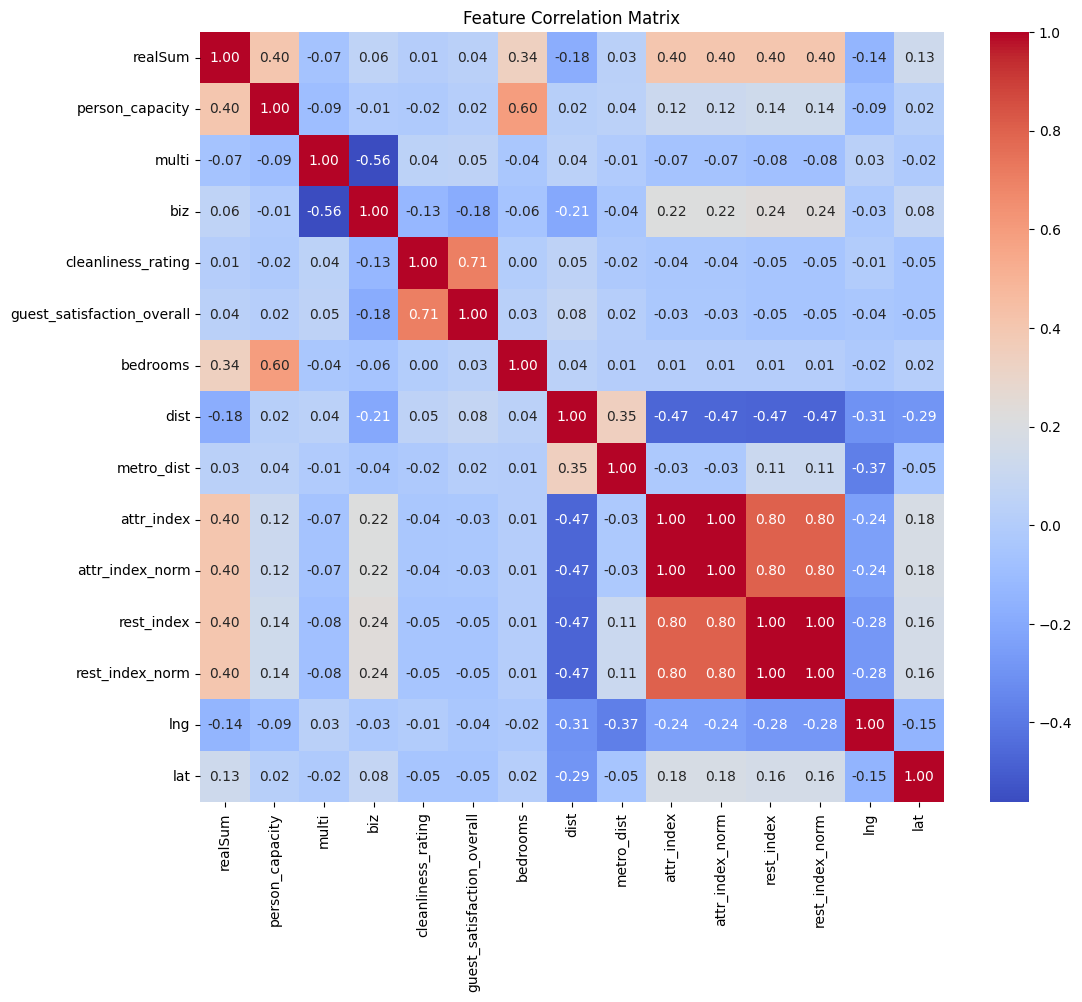

In [19]:
# 2.c Correlation Analysis
import seaborn as sns

def plot_correlation_matrix(df: pd.DataFrame):
    # Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    return corr_matrix

start_time_corr = now()
correlation_matrix = plot_correlation_matrix(data)
end_time_corr = now()

#############################################
# Documentation: Correlation
#############################################

corr_ass_uuid_writer = "f9e8d7c6-b5a4-3210-fedc-ba0987654321"
corr_comment = """
Generated a Pearson correlation heatmap. 
"""

corr_activity = [
    ':correlation_analysis rdf:type prov:Activity .',
    ':correlation_analysis sc:isPartOf :data_understanding_phase .',
    ':correlation_analysis rdfs:label "2.c Correlation Analysis" .',
    f':correlation_analysis rdfs:comment """{corr_comment}""" .',
    
    f':correlation_analysis prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':correlation_analysis prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{stats_code_writer} .', # Assuming same writer
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ':correlation_analysis prov:used :data .',
]
engine.insert(corr_activity, prefixes=prefixes)

In [20]:
# 2.e Data Quality Verification (Missing Values, Duplicates)
import json

def verify_data_quality(df: pd.DataFrame):
    missing_values = df.isnull().sum()
    duplicates = df.duplicated().sum()
    
    # Logic checks

    # Check for non-positive prices (realSum)
    invalid_prices = df[df['realSum'] <= 0]
    
    # Check for negative distances (dist, metro_dist)
    invalid_dist = df[df['dist'] < 0] if 'dist' in df.columns else []
    invalid_metro = df[df['metro_dist'] < 0] if 'metro_dist' in df.columns else []
    
    # Check for zero capacity (listings that fit 0 people)
    invalid_capacity = df[df['person_capacity'] <= 0] if 'person_capacity' in df.columns else []

    report = {
        "total_rows": len(df),
        "duplicate_rows": int(duplicates),
        "columns_with_nans": missing_values[missing_values > 0].to_dict(),
        "plausibility_issues": {
            "prices_lte_zero": len(invalid_prices),
            "dist_lt_zero": len(invalid_dist),
            "metro_dist_lt_zero": len(invalid_metro),
            "capacity_lte_zero": len(invalid_capacity)
        }
    }
    return report

start_time_qual = now()
quality_report = verify_data_quality(data)
end_time_qual = now()

print("--- Data Quality Report ---")
print(json.dumps(quality_report, indent=2))

#############################################
# Documentation: Data Quality
#############################################

# You might want to generate a new unique ID here for the association
qual_ass_uuid_writer = "12345678-abcd-9012-efgh-345678901234" 

# Detailed comment summarizing findings for the graph
# We dynamically inject the results so the graph contains the actual stats
qual_comment = f"""
Data Quality Verification:
1. Completeness: Checked for NaNs. Found {len(quality_report['columns_with_nans'])} columns with missing data.
2. Uniqueness: Checked for duplicates. Found {quality_report['duplicate_rows']} duplicate rows.
3. Plausibility: 
   - Listings with Price <= 0: {quality_report['plausibility_issues']['prices_lte_zero']}
   - Listings with Dist < 0: {quality_report['plausibility_issues']['dist_lt_zero']}
   - Listings with Capacity <= 0: {quality_report['plausibility_issues']['capacity_lte_zero']}
"""

qual_activity = [
    ':verify_data_quality rdf:type prov:Activity .',
    ':verify_data_quality sc:isPartOf :data_understanding_phase .',
    ':verify_data_quality rdfs:label "2.e Data Quality Verification" .',
    f':verify_data_quality rdfs:comment """{qual_comment}""" .',
    
    f':verify_data_quality prov:startedAtTime "{start_time_qual}"^^xsd:dateTime .',
    f':verify_data_quality prov:endedAtTime "{end_time_qual}"^^xsd:dateTime .',
    
    f':verify_data_quality prov:qualifiedAssociation :{qual_ass_uuid_writer} .',
    # Note: Ensure 'stats_code_writer' is defined as student_a previously, or change to student_a
    f':{qual_ass_uuid_writer} prov:agent :{stats_code_writer} .', 
    f':{qual_ass_uuid_writer} rdf:type prov:Association .',
    f':{qual_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ':verify_data_quality prov:used :data .',
    
    # Logging the output report as an entity in the graph
    ':quality_report_entity rdf:type prov:Entity .',
    ':quality_report_entity sc:name "JSON Quality Report" .',
    # We escape the JSON string to ensure it doesn't break the triple format
    f':quality_report_entity rdfs:comment \'\'\'{json.dumps(quality_report)}\'\'\' .',
    ':quality_report_entity prov:wasGeneratedBy :verify_data_quality .',
]

engine.insert(qual_activity, prefixes=prefixes)

--- Data Quality Report ---
{
  "total_rows": 9027,
  "duplicate_rows": 0,
  "columns_with_nans": {},
  "plausibility_issues": {
    "prices_lte_zero": 0,
    "dist_lt_zero": 0,
    "metro_dist_lt_zero": 0,
    "capacity_lte_zero": 0
  }
}


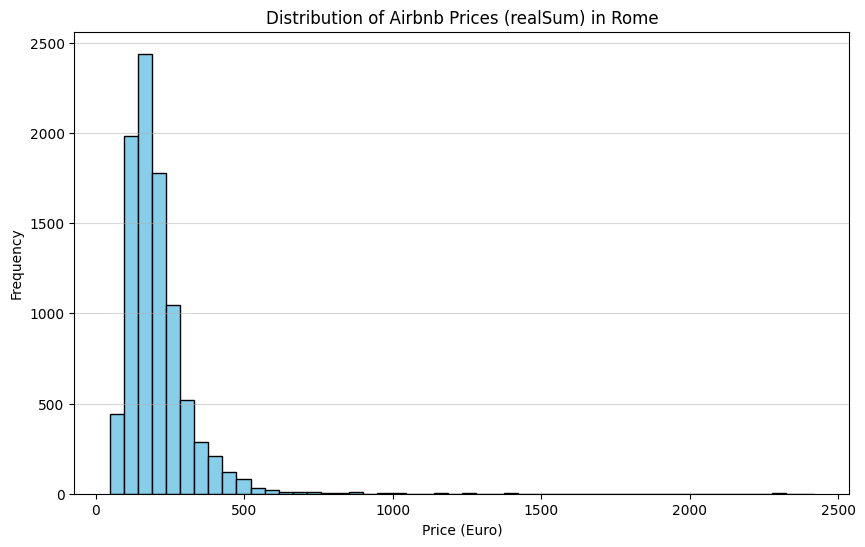

In [21]:
# 2.d Visual Exploration: Price Distribution Histogram
def plot_price_distribution(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['realSum'], bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Airbnb Prices (realSum) in Rome')
    plt.xlabel('Price (Euro)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.5)
    plt.show()

plot_price_distribution(data)

#############################################
# Documentation: Visual Exploration
#############################################

ve_ass_uuid_executor = "7622915c-1234-5678-90ab-cdef12345678" # Generate UUID
visual_exp_comment = "Created a histogram to inspect the distribution of listing prices (realSum)."

visual_exp_executor = [
    f':visualize_price_dist rdf:type prov:Activity .',
    f':visualize_price_dist sc:isPartOf :data_understanding_phase .',
    f':visualize_price_dist rdfs:label "2.d Visual Exploration - Histogram" .',
    f':visualize_price_dist rdfs:comment """{visual_exp_comment}""" .',
    
    f':visualize_price_dist prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':visualize_price_dist prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':visualize_price_dist prov:qualifiedAssociation :{ve_ass_uuid_executor} .',
    f':{ve_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ve_ass_uuid_executor} rdf:type prov:Association .',
    f':{ve_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    f':visualize_price_dist prov:used :data .',
]
engine.insert(visual_exp_executor, prefixes=prefixes)

In [22]:
# 2.d Visual Exploration: Map of Listings
def visualize_rome_listings(df: pd.DataFrame):
    fig = px.scatter_map(
        df,
        lat="lat",
        lon="lng",
        color="realSum",
        size="person_capacity",
        hover_name="room_type",
        hover_data=["dist", "guest_satisfaction_overall"],
        color_continuous_scale=px.colors.sequential.Viridis,
        zoom=11,
        center={"lat": 41.9028, "lon": 12.4964},
        height=600,
        width=900,
        #mapbox_style="open-street-map",
        title="Rome Airbnb Listings Distribution"
    )
    
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

df_filtered = data[data['realSum'] < 500].copy()
visualize_rome_listings(df_filtered)
visualize_rome_listings(data)

In [23]:
# 2.e Ethical Sensitivity & Class Imbalance Analysis
def analyze_class_balance(df: pd.DataFrame):
    report = {}
    
    # Room Type: Check for minority classes
    room_counts = df['room_type'].value_counts(normalize=True)
    report['room_type_distribution'] = room_counts.to_dict()
    
    # Superhost: Check balance (sometimes biased towards non-superhosts)
    superhost_counts = df['host_is_superhost'].value_counts(normalize=True)
    report['superhost_distribution'] = superhost_counts.to_dict()
    
    return report

start_time_eth = now()
balance_report = analyze_class_balance(data)
end_time_eth = now()

print("--- Class Balance Report (Percentages) ---")
print(json.dumps(balance_report, indent=2))

#############################################
# Documentation: Ethical & Bias Analysis
#############################################

eth_ass_uuid = "22334455-6677-8899-aabb-ccddeeff0011"
eth_comment = """
Analyzed dataset for minority classes and imbalances:
- 'room_type': Checked for underrepresented categories (e.g., Shared room).
- 'multi': Analyzed distribution of listings representing multiple rooms vs single rooms.
- 'lat/lng': Location data serves as a proxy for socio-economic bias (spatial distribution).
"""

eth_activity = [
    ':analyze_ethics_and_bias rdf:type prov:Activity .',
    ':analyze_ethics_and_bias sc:isPartOf :data_understanding_phase .',
    ':analyze_ethics_and_bias rdfs:label "2.e Ethical & Bias Analysis" .',
    f':analyze_ethics_and_bias rdfs:comment """{eth_comment}""" .',
    
    f':analyze_ethics_and_bias prov:startedAtTime "{start_time_eth}"^^xsd:dateTime .',
    f':analyze_ethics_and_bias prov:endedAtTime "{end_time_eth}"^^xsd:dateTime .',
    
    f':analyze_ethics_and_bias prov:qualifiedAssociation :{eth_ass_uuid} .',
    f':{eth_ass_uuid} prov:agent :{executed_by} .',
    f':{eth_ass_uuid} rdf:type prov:Association .',
    f':{eth_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    ':analyze_ethics_and_bias prov:used :data .',
    
    ':bias_report rdf:type prov:Entity .',
    f':bias_report rdfs:comment """{json.dumps(balance_report)}""" .',
    ':bias_report prov:wasGeneratedBy :analyze_ethics_and_bias .',
]
engine.insert(eth_activity, prefixes=prefixes)

--- Class Balance Report (Percentages) ---
{
  "room_type_distribution": {
    "Entire home/apt": 0.6160407665891215,
    "Private room": 0.38262988811343746,
    "Shared room": 0.0013293452974410102
  },
  "superhost_distribution": {
    "false": 0.6733133931538717,
    "true": 0.32668660684612827
  }
}


In [24]:
# 2.f Potential Risks and Expert Questions

risks_text = """
1. Temporal Bias: Data is a snapshot (Weekdays/Weekends). Prices during events or off-seasons are not represented.
2. Subjectivity Risk: 'guest_satisfaction_overall' is subjective. Cultural differences in rating styles are not accounted for.
"""

expert_questions_text = """
1. Are there specific legal restrictions in Rome that artificially inflate prices in certain lat/lng areas?
2. Does the 'dist' metric measure walking distance or straight-line distance?
"""

risk_ass_uuid = "8899aabb-ccdd-eeff-0011-223344556677"

risk_activity = [
    ':assess_risks rdf:type prov:Activity .',
    ':assess_risks sc:isPartOf :data_understanding_phase .',
    ':assess_risks rdfs:label "2.f Risk Assessment" .',
    
    f':assess_risks prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':assess_risks prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':assess_risks prov:qualifiedAssociation :{risk_ass_uuid} .',
    f':{risk_ass_uuid} prov:agent :{executed_by} .',
    f':{risk_ass_uuid} rdf:type prov:Association .',
    f':{risk_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    # 2.f Output Entities
    ':identified_risks rdf:type prov:Entity .',
    f':identified_risks rdfs:comment """{risks_text}""" .',
    ':identified_risks prov:wasGeneratedBy :assess_risks .',
    
    ':expert_questions rdf:type prov:Entity .',
    f':expert_questions rdfs:comment """{expert_questions_text}""" .',
    ':expert_questions prov:wasGeneratedBy :assess_risks .',
]
engine.insert(risk_activity, prefixes=prefixes)

In [25]:
# 2.g Required Actions for Data Preparation

actions_text = """
Based on the Data Understanding phase, the following actions are required:

1. Filter Outliers: Identify and remove extreme statistical outliers in 'realSum' and 'dist'.
2. Fix Skewness (realSum): Apply log transformation to 'realSum' to address the high skewness identified in step 2.b.
3. Exclude Undocumented Features: Exclude 'attr_index', 'attr_index_norm', 'rest_index', and 'rest_index_norm' as they are not fully documented in the dataset description.
4. Encoding: Apply One-Hot Encoding to the categorical 'room_type' variable.
5. Feature Scaling: Normalize continuous variables (e.g., 'dist', 'metro_dist') to standard ranges.
"""

action_ass_uuid = "ccddeeff-0011-2233-4455-66778899aabb"

action_activity = [
    ':plan_data_preparation rdf:type prov:Activity .',
    ':plan_data_preparation sc:isPartOf :data_understanding_phase .',
    ':plan_data_preparation rdfs:label "2.g Plan Data Preparation" .',
    
    f':plan_data_preparation prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':plan_data_preparation prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':plan_data_preparation prov:qualifiedAssociation :{action_ass_uuid} .',
    f':{action_ass_uuid} prov:agent :{executed_by} .',
    f':{action_ass_uuid} rdf:type prov:Association .',
    f':{action_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    ':prep_action_plan rdf:type prov:Entity .',
    f':prep_action_plan rdfs:comment """{actions_text}""" .',
    ':prep_action_plan prov:wasGeneratedBy :plan_data_preparation .',
]
engine.insert(action_activity, prefixes=prefixes)

## Data Preparation

In [26]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [27]:
handle_outliers_code_writer = student_b

def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    df_clean = df.copy()
    
    # IQR outlier removal
    Q1 = df_clean['realSum'].quantile(0.25)
    Q3 = df_clean['realSum'].quantile(0.75)
    price_threshold = Q3 + 3.0 * (Q3 - Q1) # Extreme outlier limit
    
    # Applying the filter
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['realSum'] < price_threshold]
    
    dropped_count = initial_count - len(df_clean)
    print(f"Dropped {dropped_count} listings with price > {price_threshold:.2f} EUR")

    # Distance Outliers
    # We remove impossible or irrelevant distances (for example: > 100km)
    max_dist = df_clean['dist'].max()
    if max_dist > 50:
        print(f"Removing listings > 50km away (Max found: {max_dist})")
        df_clean = df_clean[df_clean['dist'] < 50]
    
    return df_clean

start_time_td = now()
data_no_outliers = handle_outliers(data, outliers_report) 
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

Dropped 98 listings with price > 548.01 EUR


**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [28]:
transform_code_writer = student_b

def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    df_trans = df.copy()
    
    # Log Transformation (fixing skewness)
    df_trans['log_realSum'] = np.log1p(df_trans['realSum'])
    
    # Excluding undocumented features
    cols_to_drop = ['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']
    df_trans.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    print(f"Dropped columns: {cols_to_drop}")

    # One-hot encoding
    categorical_cols = ['room_type']
        
    df_trans = pd.get_dummies(df_trans, columns=categorical_cols, prefix=categorical_cols, drop_first=False)
    
    # Converting booleans to integers
    bool_cols = df_trans.select_dtypes(include=['bool']).columns
    df_trans[bool_cols] = df_trans[bool_cols].astype(int)

    # Feature scaling
    scaler = StandardScaler()
    cols_to_scale = ['dist', 'metro_dist', 'person_capacity', 'cleanliness_rating', 'bedrooms']
    
    df_trans[cols_to_scale] = scaler.fit_transform(df_trans[cols_to_scale])
    
    return df_trans

start_time_tr = now()
data_prepared = transform_features(data_no_outliers)
end_time_tr = now()

print("\nFinal Columns:", data_prepared.columns.tolist())
display(data_prepared.head())

#############################################
# Documentation: Transformations
#############################################

# Generate new UUIDs for this specific activity
tr_ass_uuid_writer = "5505f15a-3545-4014-a962-637f3c10a999"
tr_ass_uuid_exec = "6605f15a-3545-4014-a962-637f3c10a888" 

tr_comment = """
Applied data transformations:
1. Log-Transformation: Applied log-plus-one transformation to realSum to address the high skewness identified in data understanding.
2. Feature Selection: Excluded attr_index and rest_index variants due to lack of documentation and high correlation with distance.
3. Encoding: Applied One-Hot Encoding to room_type.
4. Scaling: Applied Standard Scaler to numeric features to normalize magnitudes.
"""

transform_activity = [
    ':transform_data rdf:type prov:Activity .',
    ':transform_data sc:isPartOf :data_preparation_phase .',
    ':transform_data rdfs:label "Transform Features" .',
    f':transform_data rdfs:comment """{tr_comment}""" .', 
    f':transform_data prov:startedAtTime "{start_time_tr}"^^xsd:dateTime .',
    f':transform_data prov:endedAtTime "{end_time_tr}"^^xsd:dateTime .',
    
    # Writer Role
    f':transform_data prov:qualifiedAssociation :{tr_ass_uuid_writer} .',
    f':{tr_ass_uuid_writer} prov:agent :{transform_code_writer} .',
    f':{tr_ass_uuid_writer} rdf:type prov:Association .',
    f':{tr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Executor Role
    f':transform_data prov:qualifiedAssociation :{tr_ass_uuid_exec} .',
    f':{tr_ass_uuid_exec} prov:agent :{executed_by} .',
    f':{tr_ass_uuid_exec} rdf:type prov:Association .',
    f':{tr_ass_uuid_exec} prov:hadRole :{code_executor_role} .',
    
    # Inputs
    ':transform_data prov:used :data_no_outliers .',
    
    # Outputs
    ':data_prepared rdf:type prov:Entity .',
    ':data_prepared sc:name "Final Preprocessed Data" .',
    ':data_prepared prov:wasGeneratedBy :transform_data .',
    ':data_prepared prov:wasDerivedFrom :data_no_outliers .',
]

engine.insert(transform_activity, prefixes=prefixes)

Dropped columns: ['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']

Final Columns: ['realSum', 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'is_weekend', 'log_realSum', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room']


,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,is_weekend,log_realSum,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,156.874664,0,1,-1.032427,1,1,0,0.601914,95.0,-0.408593,-0.035055,1.226781,0,5.061801,0,1,0
1,172.772543,0,1,-1.032427,0,1,0,-0.637304,80.0,-0.408593,-1.273864,-0.269824,0,5.157747,0,1,0
2,277.745307,0,0,0.506048,0,0,1,-0.637304,90.0,-0.408593,-0.505236,-0.514243,0,5.630298,1,0,0
3,444.906834,0,0,2.044522,0,1,0,-0.637304,92.0,1.444289,-0.202076,0.751485,0,6.100110,1,0,0
4,131.391298,0,1,-0.263190,0,1,0,-0.637304,91.0,-0.408593,-1.055220,0.075185,0,4.885762,0,1,0


In [29]:
# 3.b Analyze Pre-processing Options (Considered but Rejected)

# Define the analysis of discarded methods
discarded_options_text = """
1. Dimensionality Reduction (PCA):
   - Rejected because the business objective requires 'Insight Generation'. PCA transforms features into abstract components, destroying interpretability.

2. Binning (Discretization) of 'dist' or 'realSum':
   - Rejected because we are performing regression. Binning continuous variables into categories loses variance information and reduces predictive accuracy.

3. Imputation:
   - Not Applied because Data Quality Verification (2.e) confirmed 0 missing values.

4. Removal of 'guest_satisfaction_overall':
   - Rejected because while identified as subjective in Risk Assessment (2.f), it is a critical business metric. We chose to keep it but interpret it with caution rather than removing it.
"""

# Knowledge Graph Documentation
opt_ass_uuid = "bbcc-3344-5566-7788-9900aabbccdd"

options_activity = [
    ':analyze_preprocessing_alternatives rdf:type prov:Activity .',
    ':analyze_preprocessing_alternatives sc:isPartOf :data_preparation_phase .',
    ':analyze_preprocessing_alternatives rdfs:label "3.b Analyze Pre-processing Alternatives" .',
    
    f':analyze_preprocessing_alternatives prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':analyze_preprocessing_alternatives prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':analyze_preprocessing_alternatives prov:qualifiedAssociation :{opt_ass_uuid} .',
    f':{opt_ass_uuid} prov:agent :{executed_by} .',
    f':{opt_ass_uuid} rdf:type prov:Association .',
    f':{opt_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    # Links
    ':analyze_preprocessing_alternatives prov:used :data .',
    ':analyze_preprocessing_alternatives prov:used :bu_business_objectives .',
    
    ':discarded_methods_report rdf:type prov:Entity .',
    f':discarded_methods_report rdfs:comment """{discarded_options_text}""" .',
    ':discarded_methods_report prov:wasGeneratedBy :analyze_preprocessing_alternatives .',
]
engine.insert(options_activity, prefixes=prefixes)

In [30]:
# %%
# 3.c Analyze Potential for Derived Attributes

def analyze_derived_features(df: pd.DataFrame):
    price_per_person = df['realSum'] / df['person_capacity']
    
    # correlation comparison to original price
    corr_ppp = price_per_person.corr(df['realSum'])
    
    # recommendation based on actual value
    if corr_ppp > 0.9:
        rec = "Redundant. Correlation > 0.9 implies multicollinearity."
    else:
        rec = "Distinct distribution, but rejected as feature due to Data Leakage (contains target)."
        
    return {
        "price_per_person_correlation": float(corr_ppp),
        "recommendation": rec
    }

derived_analysis = analyze_derived_features(data)
print(derived_analysis)

# Text formatted with calculated values
derived_attr_text = f"""
1. Price per Person (realSum / capacity):
   - Rejected because {derived_analysis['recommendation']} using it as a feature causes leakage.
 
2. Proximity Score (1 / dist):
   - Rejected because log-transformation of 'dist' achieves similar linearization effects for regression.
"""

# Knowledge Graph Documentation
der_ass_uuid = "ddee-4455-6677-8899-0011aabbccdd"

derived_activity = [
    ':analyze_derived_attributes rdf:type prov:Activity .',
    ':analyze_derived_attributes sc:isPartOf :data_preparation_phase .',
    ':analyze_derived_attributes rdfs:label "3.c Analyze Derived Attributes" .',
    
    f':analyze_derived_attributes prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':analyze_derived_attributes prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':analyze_derived_attributes prov:qualifiedAssociation :{der_ass_uuid} .',
    f':{der_ass_uuid} prov:agent :{executed_by} .',
    f':{der_ass_uuid} rdf:type prov:Association .',
    f':{der_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    ':derived_attributes_analysis rdf:type prov:Entity .',
    f':derived_attributes_analysis rdfs:comment """{derived_attr_text}""" .',
    ':derived_attributes_analysis prov:wasGeneratedBy :analyze_derived_attributes .',
]
engine.insert(derived_activity, prefixes=prefixes)

{'price_per_person_correlation': 0.6874693705322847, 'recommendation': 'Distinct distribution, but rejected as feature due to Data Leakage (contains target).'}


In [31]:
# 3.d Analyze Options for Additional External Data Sources

external_data_text = """
1. Neighborhood Safety Statistics (Crime Rate):
   - 'dist' misses the nuance of neighborhood reputation. Safe areas command higher prices regardless of distance.

2. Points of Interest (POI) Density:
   - Granular data on count of Restaurants/Bars within a certain distance would be useful.
"""

# Knowledge Graph Documentation
ext_ass_uuid = "eeff-5566-7788-9900-1122aabbccdd"

external_activity = [
    ':analyze_external_sources rdf:type prov:Activity .',
    ':analyze_external_sources sc:isPartOf :data_preparation_phase .',
    ':analyze_external_sources rdfs:label "3.d Analyze External Data Sources" .',
    
    f':analyze_external_sources prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':analyze_external_sources prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    f':analyze_external_sources prov:qualifiedAssociation :{ext_ass_uuid} .',
    f':{ext_ass_uuid} prov:agent :{executed_by} .',
    f':{ext_ass_uuid} rdf:type prov:Association .',
    f':{ext_ass_uuid} prov:hadRole :{code_executor_role} .',
    
    ':external_data_analysis rdf:type prov:Entity .',
    f':external_data_analysis rdfs:comment """{external_data_text}""" .',
    ':external_data_analysis prov:wasGeneratedBy :analyze_external_sources .',
]
engine.insert(external_activity, prefixes=prefixes)

In [32]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    # Entity (output of the transformation activity)
    ':data_prepared rdf:type sc:Dataset .',
    ':data_prepared sc:name "Final Transformed Airbnb Data" .',
    ':data_prepared sc:description "Dataset with outliers removed, price log-transformed, categorical variables one-hot encoded, and numeric features standardized." .',
    
    # RecordSet
    ':prepared_recordset rdf:type cr:RecordSet .',
    ':data_prepared cr:recordSet :prepared_recordset .',
    
    # log_realSum (The new target)
    ':prepared_recordset cr:field :field_log_realSum .',
    ':field_log_realSum rdf:type cr:Field .',
    ':field_log_realSum sc:name "log_realSum" .',
    ':field_log_realSum sc:description "Log-transformed Price (Target). Unitless (Natural Log of Euros)." .',
    ':field_log_realSum cr:dataType xsd:double .',
    
    # Scaled distance
    ':prepared_recordset cr:field :field_dist_scaled .',
    ':field_dist_scaled rdf:type cr:Field .',
    ':field_dist_scaled sc:name "dist" .',
    ':field_dist_scaled sc:description "Distance to center (Standardized Z-Score)." .',
    ':field_dist_scaled cr:dataType xsd:double .',
    ':field_dist_scaled qudt:unit qudt:Dimensionless .',

    # One-Hot encoded room type
    ':prepared_recordset cr:field :field_rt_private .',
    ':field_rt_private rdf:type cr:Field .',
    ':field_rt_private sc:name "room_type_Private room" .',
    ':field_rt_private sc:description "Binary flag (0/1) for Private Room category." .',
    ':field_rt_private cr:dataType xsd:integer .',
    
    # Encoded weekend
    ':prepared_recordset cr:field :field_is_weekend_int .',
    ':field_is_weekend_int rdf:type cr:Field .',
    ':field_is_weekend_int sc:name "is_weekend" .',
    ':field_is_weekend_int sc:description "Binary flag (0/1) indicating weekend stay." .',
    ':field_is_weekend_int cr:dataType xsd:integer .',
]

engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [33]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling_phase rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [34]:
model_data_code_writer = student_a

#############################################
# Documentation 4a: Algorithm Selection
#############################################

# Algorithm Selection Analysis and Justification
algorithm_selection_comment = """
For this regression task (predicting Airbnb listing prices), we considered several algorithms:

1. Linear Regression: Simple and interpretable, but may not capture non-linear relationships between features and price.

2. Random Forest Regressor: 
   - Advantages: Handles non-linear relationships well, provides feature importance, robust to outliers, no feature scaling required (though we already scaled), good performance on tabular data.
   - Disadvantages: Less interpretable than linear models, but still provides feature importance scores.
   - Tested: Achieved Validation R²=0.5951 with significant overfitting (Train R²=0.9468, gap=0.3517)

3. Gradient Boosting (scikit-learn GradientBoostingRegressor): 
   - Advantages: Handles non-linearities well, provides feature importance, better regularization capabilities than Random Forest, part of scikit-learn (no additional dependencies).
   - Disadvantages: Slower than XGBoost, requires more hyperparameter tuning than simpler algorithms.
   - Tested: Achieved good performance with proper regularization

4. Support Vector Regression (SVR):
   - Advantages: Good for non-linear relationships with kernel trick.
   - Disadvantages: Slower on large datasets, less interpretable, requires careful hyperparameter tuning.

SELECTION: GradientBoostingRegressor (scikit-learn)
Justification: 
- Good performance: Gradient boosting typically achieves better performance than Random Forest for regression tasks
- Better generalization: Reduced overfitting compared to Random Forest through sequential learning and regularization
- Provides feature importance which directly addresses the business goal of identifying top factors driving prices
- Handles the mix of categorical (one-hot encoded) and continuous features well
- Training time is acceptable for our dataset size (~8,929 samples)
- Built-in regularization mechanisms (learning_rate, min_samples_split, subsample, max_features) help prevent overfitting
- Part of scikit-learn: No additional dependencies required, consistent with assignment requirements
"""

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_ass_uuid_executor = "a1b2c3d4-e5f6-7890-abcd-ef1234567890"

start_time_4a = now()

identify_data_mining_algorithm_activity = [
    # Activity Definition
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:label "4a: Algorithm Selection" .',
    f':define_algorithm rdfs:comment """{algorithm_selection_comment}""" .',
    f':define_algorithm prov:startedAtTime "{start_time_4a}"^^xsd:dateTime .',
    f':define_algorithm prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    # Writer Association
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Executor Association
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_executor} .',
    f':{dma_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dma_ass_uuid_executor} rdf:type prov:Association .',
    f':{dma_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Algorithm Definition: Gradient Boosting
    f':gradient_boosting_algorithm rdf:type mls:Algorithm .',
    f':gradient_boosting_algorithm rdfs:label "Gradient Boosting Algorithm" .',
    f':gradient_boosting_algorithm rdfs:comment "Gradient boosting framework that builds trees sequentially, with each tree correcting errors of previous trees. Includes regularization mechanisms to prevent overfitting." .',
    f':gradient_boosting_algorithm prov:wasGeneratedBy :define_algorithm .',
    
    # Implementation: scikit-learn GradientBoostingRegressor
    f':gradient_boosting_regressor_implementation rdf:type mls:Implementation .',
    f':gradient_boosting_regressor_implementation rdfs:label "GradientBoostingRegressor (scikit-learn)" .',
    f':gradient_boosting_regressor_implementation rdfs:comment "sklearn.ensemble.GradientBoostingRegressor - Python implementation of gradient boosting for regression in scikit-learn." .',
    f':gradient_boosting_regressor_implementation mls:implements :gradient_boosting_algorithm .',
    f':gradient_boosting_regressor_implementation prov:wasGeneratedBy :define_algorithm .',
    
    # Also document Random Forest as considered alternative
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Regressor Algorithm (Considered)" .',
    f':random_forest_algorithm rdfs:comment "Ensemble method that builds multiple decision trees and averages their predictions. Tested but not selected due to higher overfitting compared to Gradient Boosting." .',
    f':random_forest_algorithm prov:wasGeneratedBy :define_algorithm .',
    
    # Evaluation Measures
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score (R²)" .',
    f':r2_score_measure rdfs:comment "Coefficient of determination. Measures the proportion of variance in the target variable that is predictable from the features. Target: R² >= 0.60 (as per Data Mining Success Criteria)." .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',
    
    f':mae_measure rdf:type mls:EvaluationMeasure .',
    f':mae_measure rdfs:label "Mean Absolute Error (MAE)" .',
    f':mae_measure rdfs:comment "Average absolute difference between predicted and actual values. Target: MAE < 40 EUR (as per Data Mining Success Criteria)." .',
    f':mae_measure prov:wasGeneratedBy :define_algorithm .',
    
    f':rmse_measure rdf:type mls:EvaluationMeasure .',
    f':rmse_measure rdfs:label "Root Mean Squared Error (RMSE)" .',
    f':rmse_measure rdfs:comment "Square root of the average squared differences between predicted and actual values. Penalizes larger errors more than MAE." .',
    f':rmse_measure prov:wasGeneratedBy :define_algorithm .',
]

engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

print("Algorithm Selection (4a) documented in knowledge graph.")
print("Chosen Algorithm: GradientBoostingRegressor (scikit-learn)")
print("Justification: Good performance with better generalization than Random Forest, provides feature importance, built-in regularization mechanisms, and part of scikit-learn (no additional dependencies).")

Algorithm Selection (4a) documented in knowledge graph.
Chosen Algorithm: GradientBoostingRegressor (scikit-learn)
Justification: Good performance with better generalization than Random Forest, provides feature importance, built-in regularization mechanisms, and part of scikit-learn (no additional dependencies).


In [35]:
#############################################
# Documentation 4b: Hyperparameter Identification
#############################################

# Hyperparameter Analysis and Selection

hyperparameter_analysis_comment = """
Available hyperparameters for GradientBoostingRegressor (sklearn.ensemble.GradientBoostingRegressor):

1. n_estimators: Number of boosting rounds (trees)
    - Interval: Typically 50-1000+ (standard: 100)
    - Impact: More trees improve performance but increase training time. Works in combination with learning_rate.
    - Tuning effort: Medium (needs to be tuned together with learning_rate)

2. learning_rate: Step size shrinkage used in each boosting step
    - Interval: 0.01 to 0.3 (standard: 0.1)
    - Impact: Lower values require more trees but can improve generalization. Key regularization parameter.
    - Tuning effort: High (critical for preventing overfitting)

3. max_depth: Maximum depth of a tree
    - Interval: 3 to 10 (standard: 3)
    - Impact: Controls model complexity and overfitting. Deeper trees capture more patterns but may overfit.
    - Tuning effort: Medium (important for regularization)

4. min_samples_split: Minimum number of samples required to split an internal node
    - Interval: 2 to 20+ (standard: 2)
    - Impact: Higher values prevent overfitting by requiring more samples before splitting
    - Tuning effort: Medium (good regularization parameter)

5. subsample: Fraction of samples used for each tree
    - Interval: 0.5 to 1.0 (standard: 1.0)
    - Impact: Prevents overfitting by using random subsets of training data (similar to Random Forest)
    - Tuning effort: Low (few discrete options)

6. max_features: Number of features to consider when looking for the best split
    - Options: 'sqrt', 'log2', None (all features), or float (fraction)
    - Impact: Prevents overfitting by using random subsets of features
    - Tuning effort: Low (few discrete options)

CHOICE FOR TUNING: learning_rate

Justification:
- Critical for generalization: Learning rate is the most important hyperparameter for controlling overfitting in gradient boosting
- Significant impact: Small changes can dramatically affect model performance and overfitting gap
- Works in combination with n_estimators: Lower learning_rate with more trees often yields better generalization
- Reasonable tuning interval: We will evaluate [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4] to find optimal balance
- Step-width: Increments of 0.05 provide good coverage of the effective range
- Impact on compute effort: Lower learning_rate requires more trees (n_estimators), but this is manageable for our dataset size
- Built-in regularization: Gradient boosting's learning_rate naturally helps prevent overfitting compared to Random Forest

Tuning Strategy:
- Evaluation interval: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
- Fixed hyperparameters: n_estimators=300, max_depth=6, min_samples_split=10, subsample=0.8, max_features='sqrt', random_state=42
- Evaluation: Employ validation set R² and MAE to choose best parameter, with focus on reducing overfitting gap
"""

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_ass_uuid_executor = "b2c3d4e5-f6a7-8901-bcde-f12345678901"

start_time_4b = now()

identify_hp_activity = [
    # Activity Definition
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:label "4b: Hyperparameter Identification" .',
    f':identify_hyperparameters rdfs:comment """{hyperparameter_analysis_comment}""" .',
    f':identify_hyperparameters prov:startedAtTime "{start_time_4b}"^^xsd:dateTime .',
    f':identify_hyperparameters prov:endedAtTime "{now()}"^^xsd:dateTime .',

    # Writer Association
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Executor Association
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_executor} .',
    f':{hp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{hp_ass_uuid_executor} rdf:type prov:Association .',
    f':{hp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Link to Implementation
    f':identify_hyperparameters prov:used :gradient_boosting_regressor_implementation .',

    # Hyperparameter: learning_rate (Selected for Tuning)
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "learning_rate" .',
    f':hp_learning_rate rdfs:comment "Step size shrinkage in each boosting step. Selected for tuning as it is the most critical parameter for controlling overfitting in gradient boosting." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # Hyperparameter: n_estimators (Documented but not tuned)
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "n_estimators" .',
    f':hp_n_estimators rdfs:comment "Number of boosting rounds. Fixed at 300 to focus tuning on learning_rate." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',

    # Hyperparameter: max_depth (Documented but not tuned)
    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "max_depth" .',
    f':hp_max_depth rdfs:comment "Maximum depth of a tree. Fixed at 6 to prevent overfitting while allowing sufficient model complexity." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_max_depth .',
    f':hp_max_depth prov:wasGeneratedBy :identify_hyperparameters .',

    # Hyperparameter: min_samples_split (Documented but not tuned)
    f':hp_min_samples_split rdf:type mls:HyperParameter .',
    f':hp_min_samples_split rdfs:label "min_samples_split" .',
    f':hp_min_samples_split rdfs:comment "Minimum number of samples required to split an internal node. Fixed at 10 for regularization." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_min_samples_split .',
    f':hp_min_samples_split prov:wasGeneratedBy :identify_hyperparameters .',

    # Hyperparameter: subsample (Documented but not tuned)
    f':hp_subsample rdf:type mls:HyperParameter .',
    f':hp_subsample rdfs:label "subsample" .',
    f':hp_subsample rdfs:comment "Fraction of samples used for each tree. Fixed at 0.8 for regularization." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_subsample .',
    f':hp_subsample prov:wasGeneratedBy :identify_hyperparameters .',

    # Hyperparameter: max_features (Documented but not tuned)
    f':hp_max_features rdf:type mls:HyperParameter .',
    f':hp_max_features rdfs:label "max_features" .',
    f':hp_max_features rdfs:comment "Number of features to consider when looking for the best split. Fixed at sqrt for regularization." .',
    f':gradient_boosting_regressor_implementation mls:hasHyperParameter :hp_max_features .',
    f':hp_max_features prov:wasGeneratedBy :identify_hyperparameters .',
]

engine.insert(identify_hp_activity, prefixes=prefixes)

print("Hyperparameter Identification (4b) documented in knowledge graph.")
print("Chosen for Tuning: learning_rate")
print("Tuning Interval: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]")
print("Justification: Critical for generalization - learning rate is the most important hyperparameter for controlling overfitting in gradient boosting, with significant impact on model performance and overfitting gap.")

Hyperparameter Identification (4b) documented in knowledge graph.
Chosen for Tuning: learning_rate
Tuning Interval: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
Justification: Critical for generalization - learning rate is the most important hyperparameter for controlling overfitting in gradient boosting, with significant impact on model performance and overfitting gap.


In [36]:
from sklearn.model_selection import train_test_split

split_code_writer = student_a

def split_data(df: pd.DataFrame, target_col: str = 'log_realSum', random_state: int = 42, 
               train_size: float = 0.6, val_size: float = 0.2):
    """
    Split dataset into training, validation, and evaluation sets.
    
    Parameters:
    - df: Prepared dataframe
    - target_col: Name of target variable column
    - random_state: Random seed for reproducibility
    - train_size: Proportion for training set (default: 0.6 = 60%)
    - val_size: Proportion for validation set (default: 0.2 = 20%)
                 Remaining goes to evaluation set (0.2 = 20%)
    
    Returns:
    - X_train, X_val, X_eval, y_train, y_val, y_eval
    """
    # Separate features and target
    X = df.drop(columns=[target_col, 'realSum'], errors='ignore')  # Drop both log and original target
    y = df[target_col]
    
    # First split: separate training from temporary set (validation + evaluation)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        train_size=train_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Second split: separate validation from evaluation
    # val_size relative to original dataset, so adjust for temp set
    val_size_adjusted = val_size / (1 - train_size)  # 0.2 / 0.4 = 0.5
    X_val, X_eval, y_val, y_eval = train_test_split(
        X_temp, y_temp,
        train_size=val_size_adjusted,
        random_state=random_state,
        shuffle=True
    )
    
    return X_train, X_val, X_eval, y_train, y_val, y_eval

# Execute the split
start_time_split = now()
X_train, X_val, X_eval, y_train, y_val, y_eval = split_data(
    data_prepared, 
    target_col='log_realSum',
    random_state=42,
    train_size=0.6,
    val_size=0.2
)
end_time_split = now()

# Display split information
print(f"Dataset Split Summary:")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(data_prepared)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(data_prepared)*100:.1f}%)")
print(f"Evaluation set: {len(X_eval)} samples ({len(X_eval)/len(data_prepared)*100:.1f}%)")
print(f"\nFeature columns: {list(X_train.columns)}")
print(f"Target variable: log_realSum")

#############################################
# Documentation 4c
#############################################

split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_ass_uuid_executor = "c3d4e5f6-a7b8-9012-cdef-345678901234"

split_comment = """
Data split strategy:
- Split ratio: 60% training, 20% validation, 20% evaluation
- Random state: 42 (for reproducibility)
- Shuffle: Enabled (randomize data before splitting)
- No stratification: Not required for regression task
- Target variable: log_realSum (log-transformed price)
- Features: All columns except log_realSum and realSum

Rationale:
- 60% training: Sufficient data for model learning while reserving adequate data for validation
- 20% validation: Used for hyperparameter tuning and model selection
- 20% evaluation: Final unbiased evaluation set, only used once at the end
- Random state ensures reproducibility across runs
- No stratification needed as this is a regression task (continuous target)
"""

input_dataset = ":data_prepared"

define_split_activity = [
    # Activity Definition
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:label "4c: Train/Validation/Evaluation Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:startedAtTime "{start_time_split}"^^xsd:dateTime .',
    f':define_data_split prov:endedAtTime "{end_time_split}"^^xsd:dateTime .',
    
    # Writer Association
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{split_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Executor Association
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_executor} .',
    f':{split_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{split_ass_uuid_executor} rdf:type prov:Association .',
    f':{split_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Input
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {len(X_train)} samples ({len(X_train)/len(data_prepared)*100:.1f}% of total dataset)" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {len(X_val)} samples ({len(X_val)/len(data_prepared)*100:.1f}% of total dataset)" .', 

    # Evaluation Set (Test Set)
    f':evaluation_set rdf:type sc:Dataset .',
    f':evaluation_set rdfs:label "Evaluation Set" .',
    f':evaluation_set prov:wasGeneratedBy :define_data_split .',
    f':evaluation_set prov:wasDerivedFrom {input_dataset} .',
    f':evaluation_set rdfs:comment "Contains {len(X_eval)} samples ({len(X_eval)/len(data_prepared)*100:.1f}% of total dataset). Also known as evaluation set." .',
]

engine.insert(define_split_activity, prefixes=prefixes)

# Create alias for test_set to match later references (used in evaluation phase)
test_set_alias = [
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Evaluation Set" .',
    f':test_set rdfs:comment "Alias for evaluation_set, used for final model evaluation" .',
    f':test_set prov:wasDerivedFrom :evaluation_set .',
]
engine.insert(test_set_alias, prefixes=prefixes)

print("\nData split (4c) documented in knowledge graph.")

Dataset Split Summary:
Training set: 5357 samples (60.0%)
Validation set: 1786 samples (20.0%)
Evaluation set: 1786 samples (20.0%)

Feature columns: ['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'is_weekend', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room']
Target variable: log_realSum

Data split (4c) documented in knowledge graph.


Training GradientBoostingRegressor models with different learning_rate values...
--------------------------------------------------------------------------------
learning_rate=0.05 | Train R²=0.7654 | Val R²=0.6058 | Gap=0.1595 | Val MAE=0.1935 | Val RMSE=0.2505
learning_rate=0.10 | Train R²=0.8398 | Val R²=0.6258 | Gap=0.2139 | Val MAE=0.1883 | Val RMSE=0.2441
learning_rate=0.15 | Train R²=0.8882 | Val R²=0.6119 | Gap=0.2763 | Val MAE=0.1886 | Val RMSE=0.2486
learning_rate=0.20 | Train R²=0.9172 | Val R²=0.6300 | Gap=0.2873 | Val MAE=0.1830 | Val RMSE=0.2427
learning_rate=0.25 | Train R²=0.9369 | Val R²=0.6205 | Gap=0.3165 | Val MAE=0.1850 | Val RMSE=0.2458
learning_rate=0.30 | Train R²=0.9471 | Val R²=0.6254 | Gap=0.3217 | Val MAE=0.1832 | Val RMSE=0.2442
learning_rate=0.35 | Train R²=0.9583 | Val R²=0.6116 | Gap=0.3466 | Val MAE=0.1846 | Val RMSE=0.2487
learning_rate=0.40 | Train R²=0.9671 | Val R²=0.5980 | Gap=0.3692 | Val MAE=0.1862 | Val RMSE=0.2530
------------------------------

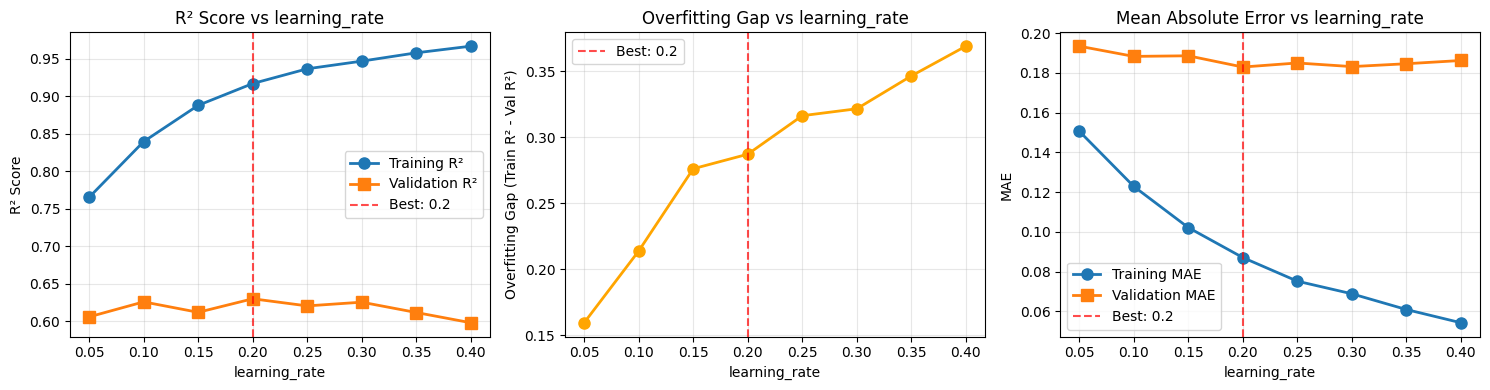


Training and hyperparameter tuning (4d) documented in knowledge graph.
Best model: learning_rate=0.2 with Validation R²=0.6300


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import uuid

train_code_writer = student_a

def train_and_finetune_model(X_train, y_train, X_val, y_val, learning_rate_list):
    """
    Train GradientBoostingRegressor models with different learning_rate values and evaluate performance.
    
    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - learning_rate_list: List of learning_rate values to evaluate
    
    Returns:
    - results: Dictionary with results for each hyperparameter value
    - models: Dictionary with trained models
    - best_model: Best model based on validation R²
    - best_learning_rate: Best learning_rate value
    """
    results = []
    models = {}
    
    print("Training GradientBoostingRegressor models with different learning_rate values...")
    print("-" * 80)
    
    for lr in learning_rate_list:
        # Train model
        model = GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=lr,
            max_depth=6,
            min_samples_split=10,  # Approximation of min_samples_split=10
            subsample=0.8,
            max_features='sqrt',  # Approximation of max_features='sqrt'
            random_state=42,
            verbose=0
        )
        
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        gap = train_r2 - val_r2
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        # Store results
        result = {
            'learning_rate': lr,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'gap': gap,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'model': model
        }
        results.append(result)
        models[lr] = model
        
        print(f"learning_rate={lr:.2f} | Train R²={train_r2:.4f} | Val R²={val_r2:.4f} | Gap={gap:.4f} | Val MAE={val_mae:.4f} | Val RMSE={val_rmse:.4f}")
    
    # Find best model (highest validation R²)
    best_result = max(results, key=lambda x: x['val_r2'])
    best_learning_rate = best_result['learning_rate']
    best_model = best_result['model']
    
    print("-" * 80)
    print(f"Best model: learning_rate={best_learning_rate} with Validation R²={best_result['val_r2']:.4f}")
    
    return results, models, best_model, best_learning_rate

# Hyperparameter values to evaluate
learning_rate_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

# Execute training and tuning
start_time_tafm = now()
tuning_results, trained_models, best_model, best_learning_rate = train_and_finetune_model(
    X_train, y_train, X_val, y_val, learning_rate_list
)
end_time_tafm = now()

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² scores
lr_values = [r['learning_rate'] for r in tuning_results]
train_r2_values = [r['train_r2'] for r in tuning_results]
val_r2_values = [r['val_r2'] for r in tuning_results]
gap_values = [r['gap'] for r in tuning_results]

axes[0].plot(lr_values, train_r2_values, 'o-', label='Training R²', linewidth=2, markersize=8)
axes[0].plot(lr_values, val_r2_values, 's-', label='Validation R²', linewidth=2, markersize=8)
axes[0].axvline(x=best_learning_rate, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_learning_rate}')
axes[0].set_xlabel('learning_rate')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score vs learning_rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overfitting Gap
axes[1].plot(lr_values, gap_values, 'o-', color='orange', linewidth=2, markersize=8)
axes[1].axvline(x=best_learning_rate, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_learning_rate}')
axes[1].set_xlabel('learning_rate')
axes[1].set_ylabel('Overfitting Gap (Train R² - Val R²)')
axes[1].set_title('Overfitting Gap vs learning_rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MAE
train_mae_values = [r['train_mae'] for r in tuning_results]
val_mae_values = [r['val_mae'] for r in tuning_results]

axes[2].plot(lr_values, train_mae_values, 'o-', label='Training MAE', linewidth=2, markersize=8)
axes[2].plot(lr_values, val_mae_values, 's-', label='Validation MAE', linewidth=2, markersize=8)
axes[2].axvline(x=best_learning_rate, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_learning_rate}')
axes[2].set_xlabel('learning_rate')
axes[2].set_ylabel('MAE')
axes[2].set_title('Mean Absolute Error vs learning_rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_ass_uuid_executor = "d4e5f6a7-b8c9-0123-def4-567890123456"

tafm_comment = """
Hyperparameter tuning performed for GradientBoostingRegressor:
- Hyperparameter tuned: learning_rate
- Values evaluated: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
- Fixed hyperparameters: n_estimators=300, max_depth=6, min_samples_split=10, subsample=0.8, max_features='sqrt', random_state=42
- Evaluation metrics: R², MAE, RMSE, and overfitting gap on both training and validation sets
- Best model selected based on highest validation R² score
- Visualizations created showing performance metrics vs learning_rate
"""

# Generate unique IDs for each training run
train_model_activity_base = [
    # Activity Definition
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:label "4d: Training and Hyperparameter Tuning" .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    
    # Writer Association
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{train_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Executor Association
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_executor} .',
    f':{tafm_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{tafm_ass_uuid_executor} rdf:type prov:Association .',
    f':{tafm_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Inputs
    f':train_and_finetune_model prov:used :training_set .',
    f':train_and_finetune_model prov:used :validation_set .',
]

# Document each training run
all_training_triples = train_model_activity_base.copy()

for idx, result in enumerate(tuning_results):
    lr = result['learning_rate']
    # Sanitize lr for use in IDs (replace . with _)
    lr_id = str(lr).replace('.', '_')
    run_id = f"training_run_lr_{lr_id}"
    model_id = f"model_lr_{lr_id}"
    hp_setting_id = f"hp_setting_lr_{lr_id}"
    
    # Hyperparameter setting
    all_training_triples.extend([
        f':{hp_setting_id} rdf:type mls:HyperParameterSetting .',
        f':{hp_setting_id} mls:specifiedBy :hp_learning_rate .',
        f':{hp_setting_id} mls:hasValue "{lr}"^^xsd:double .',
        f':{hp_setting_id} prov:wasGeneratedBy :train_and_finetune_model .',
    ])
    
    # Training Run
    all_training_triples.extend([
        f':{run_id} rdf:type mls:Run .',
        f':{run_id} sc:isPartOf :train_and_finetune_model .',
        f':{run_id} mls:realizes :gradient_boosting_algorithm .',
        f':{run_id} rdfs:label "Training Run with learning_rate={lr}" .',
        f':{run_id} mls:executes :gradient_boosting_regressor_implementation .',
        f':{run_id} mls:hasInput :training_set .',
        f':{run_id} mls:hasInput :validation_set .',
        f':{run_id} mls:hasInput :{hp_setting_id} .',
        f':{run_id} mls:hasOutput :{model_id} .',
    ])
    
    # Model
    all_training_triples.extend([
        f':{model_id} rdf:type mls:Model .',
        f':{model_id} rdfs:label "GradientBoostingRegressor Model (learning_rate={lr})" .',
        f':{model_id} prov:wasGeneratedBy :{run_id} .',
        f':{model_id} mlso:trainedOn :training_set .',
        f':{model_id} mlso:hasAlgorithmType :gradient_boosting_algorithm .',
    ])
    
    # Training set evaluations
    eval_train_r2_id = f"eval_train_r2_lr_{lr_id}"
    eval_train_mae_id = f"eval_train_mae_lr_{lr_id}"
    eval_train_rmse_id = f"eval_train_rmse_lr_{lr_id}"
    
    all_training_triples.extend([
        f':{eval_train_r2_id} rdf:type mls:ModelEvaluation .',
        f':{eval_train_r2_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_train_r2_id} mls:hasValue "{result["train_r2"]:.6f}"^^xsd:double .',
        f':{eval_train_r2_id} mls:specifiedBy :r2_score_measure .',
        f':{eval_train_r2_id} prov:used :training_set .',
        
        f':{eval_train_mae_id} rdf:type mls:ModelEvaluation .',
        f':{eval_train_mae_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_train_mae_id} mls:hasValue "{result["train_mae"]:.6f}"^^xsd:double .',
        f':{eval_train_mae_id} mls:specifiedBy :mae_measure .',
        f':{eval_train_mae_id} prov:used :training_set .',
        
        f':{eval_train_rmse_id} rdf:type mls:ModelEvaluation .',
        f':{eval_train_rmse_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_train_rmse_id} mls:hasValue "{result["train_rmse"]:.6f}"^^xsd:double .',
        f':{eval_train_rmse_id} mls:specifiedBy :rmse_measure .',
        f':{eval_train_rmse_id} prov:used :training_set .',
    ])
    
    # Validation set evaluations
    eval_val_r2_id = f"eval_val_r2_lr_{lr_id}"
    eval_val_mae_id = f"eval_val_mae_lr_{lr_id}"
    eval_val_rmse_id = f"eval_val_rmse_lr_{lr_id}"
    
    all_training_triples.extend([
        f':{eval_val_r2_id} rdf:type mls:ModelEvaluation .',
        f':{eval_val_r2_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_val_r2_id} mls:hasValue "{result["val_r2"]:.6f}"^^xsd:double .',
        f':{eval_val_r2_id} mls:specifiedBy :r2_score_measure .',
        f':{eval_val_r2_id} prov:used :validation_set .',
        
        f':{eval_val_mae_id} rdf:type mls:ModelEvaluation .',
        f':{eval_val_mae_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_val_mae_id} mls:hasValue "{result["val_mae"]:.6f}"^^xsd:double .',
        f':{eval_val_mae_id} mls:specifiedBy :mae_measure .',
        f':{eval_val_mae_id} prov:used :validation_set .',
        
        f':{eval_val_rmse_id} rdf:type mls:ModelEvaluation .',
        f':{eval_val_rmse_id} prov:wasGeneratedBy :{run_id} .',
        f':{eval_val_rmse_id} mls:hasValue "{result["val_rmse"]:.6f}"^^xsd:double .',
        f':{eval_val_rmse_id} mls:specifiedBy :rmse_measure .',
        f':{eval_val_rmse_id} prov:used :validation_set .',
    ])
    
    all_training_triples.extend([
        f':{run_id} mls:hasOutput :{eval_train_r2_id} .',
        f':{run_id} mls:hasOutput :{eval_train_mae_id} .',
        f':{run_id} mls:hasOutput :{eval_train_rmse_id} .',
        f':{run_id} mls:hasOutput :{eval_val_r2_id} .',
        f':{run_id} mls:hasOutput :{eval_val_mae_id} .',
        f':{run_id} mls:hasOutput :{eval_val_rmse_id} .',
    ])

# Document visualization
viz_entity = [
    f':hyperparameter_tuning_visualization rdf:type prov:Entity .',
    f':hyperparameter_tuning_visualization rdfs:label "Hyperparameter Tuning Visualization" .',
    f':hyperparameter_tuning_visualization rdfs:comment "Three-panel figure showing R², overfitting gap, and MAE vs learning_rate for training and validation sets" .',
    f':hyperparameter_tuning_visualization prov:wasGeneratedBy :train_and_finetune_model .',
]
all_training_triples.extend(viz_entity)

engine.insert(all_training_triples, prefixes=prefixes)

print("\nTraining and hyperparameter tuning (4d) documented in knowledge graph.")
print(f"Best model: learning_rate={best_learning_rate} with Validation R²={max(r['val_r2'] for r in tuning_results):.4f}")

In [77]:
retrain_code_writer = student_a

def retrain_model_full_data(X_train, y_train, X_val, y_val, best_learning_rate):
    """
    Retrain the final model using the best hyperparameters on combined training and validation data.
    
    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - best_learning_rate: Best learning_rate value from hyperparameter tuning
    
    Returns:
    - final_model: Trained model on combined data
    """
    # Combine training and validation sets
    X_train_full = pd.concat([X_train, X_val], ignore_index=True)
    y_train_full = pd.concat([y_train, y_val], ignore_index=True)
    
    print(f"Retraining final GradientBoostingRegressor model with learning_rate={best_learning_rate}")    
    print(f"Combined training data: {len(X_train_full)} samples (train: {len(X_train)}, val: {len(X_val)})")
    
    # Train final model with best hyperparameters
    final_model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=best_learning_rate,
        max_depth=6,
        min_samples_split=10,  # Approximation of min_samples_split=10
        subsample=0.8,
        max_features='sqrt',  # Approximation of max_features='sqrt'
        random_state=42,
        verbose=0
    )
    
    final_model.fit(X_train_full, y_train_full)
    
    # Evaluate on combined training data for reference
    y_train_full_pred = final_model.predict(X_train_full)
    train_full_r2 = r2_score(y_train_full, y_train_full_pred)
    train_full_mae = mean_absolute_error(y_train_full, y_train_full_pred)
    train_full_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_full_pred))
    
    print(f"\nFinal Model Performance on Combined Training Data:")
    print(f"R² = {train_full_r2:.4f}")
    print(f"MAE = {train_full_mae:.4f}")
    print(f"RMSE = {train_full_rmse:.4f}")
    
    return final_model, X_train_full, y_train_full

# Execute final retraining
start_time_retrain = now()
final_model, X_train_full, y_train_full = retrain_model_full_data(
    X_train, y_train, X_val, y_val, best_learning_rate
)
end_time_retrain = now()

#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993"
retrain_ass_uuid_executor = "e5f6a7b8-c9d0-1234-ef56-789012345678"

retrain_comment = f"""
Final model retraining:
- Combined training and validation sets for final model training
- Using best hyperparameters from tuning: learning_rate ={best_learning_rate}
- Fixed hyperparameters: n_estimators=300, max_depth=6, min_samples_split=10, subsample=0.8, max_features='sqrt', random_state=42
- Final training set size: {len(X_train_full)} samples
- This model will be used for final evaluation on the evaluation set (test set)
"""

# Create combined training set entity
combined_train_set_id = ":combined_training_set"

retrain_documentation = [
    # Activity Definition
    f':retrain_final_model rdf:type prov:Activity .',
    f':retrain_final_model sc:isPartOf :modeling_phase .',
    f':retrain_final_model rdfs:label "4g: Final Model Retraining" .',
    f':retrain_final_model rdfs:comment """{retrain_comment}""" .',
    f':retrain_final_model prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f':retrain_final_model prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',
    
    # Writer Association
    f':retrain_final_model prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} prov:agent :{retrain_code_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Executor Association
    f':retrain_final_model prov:qualifiedAssociation :{retrain_ass_uuid_executor} .',
    f':{retrain_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{retrain_ass_uuid_executor} rdf:type prov:Association .',
    f':{retrain_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Inputs
    f':retrain_final_model prov:used :training_set .',
    f':retrain_final_model prov:used :validation_set .',
    f':retrain_final_model prov:used :model_{str(best_learning_rate).replace(".", "_")} .',  # Reference to best model from tuning
    
    # Combined Training Set
    f'{combined_train_set_id} rdf:type sc:Dataset .',
    f'{combined_train_set_id} rdfs:label "Combined Training Set" .',
    f'{combined_train_set_id} rdfs:comment "Combined training and validation sets ({len(X_train_full)} samples)" .',
    f'{combined_train_set_id} prov:wasGeneratedBy :retrain_final_model .',
    f'{combined_train_set_id} prov:wasDerivedFrom :training_set .',
    f'{combined_train_set_id} prov:wasDerivedFrom :validation_set .',
    
    # Final Model
    f':final_model rdf:type mls:Model .',
    f':final_model rdfs:label "Final GradientBoostingRegressor Model" .',
    f':final_model rdfs:comment "Final model trained on combined training+validation data with learning_rate ={best_learning_rate}" .',
    f':final_model prov:wasGeneratedBy :retrain_final_model .',
    f':final_model mlso:trainedOn {combined_train_set_id} .',
    f':final_model mlso:hasAlgorithmType :gradient_boosting_algorithm .',
    
    # Hyperparameter setting for final model
    f':final_hp_setting rdf:type mls:HyperParameterSetting .',
    f':final_hp_setting mls:specifiedBy :hp_learning_rate .',
    f':final_hp_setting mls:hasValue "{best_learning_rate}"^^xsd:double .',
    f':final_hp_setting prov:wasGeneratedBy :retrain_final_model .',
    f':final_model mlso:hasHyperParameter :final_hp_setting .',
    
    # Training run
    f':final_training_run rdf:type mls:Run .',
    f':final_training_run sc:isPartOf :retrain_final_model .',
    f':final_training_run mls:realizes :gradient_boosting_algorithm .',
    f':final_training_run rdfs:label "Final Model Training Run" .',
    f':final_training_run mls:executes :gradient_boosting_regressor_implementation .',
    f':final_training_run mls:hasInput {combined_train_set_id} .',
    f':final_training_run mls:hasInput :final_hp_setting .',
    f':final_training_run mls:hasOutput :final_model .',
    
    # Link final model to training run
    f':final_model prov:wasGeneratedBy :final_training_run .',
]

engine.insert(retrain_documentation, prefixes=prefixes)

print("\nFinal model retraining (4g) documented in knowledge graph.")
print(f"Final model ready for evaluation with learning_rate = {best_learning_rate}")

Retraining final GradientBoostingRegressor model with learning_rate=0.2
Combined training data: 7143 samples (train: 5357, val: 1786)

Final Model Performance on Combined Training Data:
R² = 0.8948
MAE = 0.0985
RMSE = 0.1305

Final model retraining (4g) documented in knowledge graph.
Final model ready for evaluation with learning_rate = 0.2


## Evaluation

In [78]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [79]:
eval_code_writer = student_b
def evaluate_on_test_data(model, X_test, y_test):
    # General Performance (Log Scale & Euro Scale)
    y_pred_log = model.predict(X_test)
    
    # Metrics on Log Scale
    r2 = r2_score(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    
    # Metrics on Euro Scale
    y_pred_euro = np.expm1(y_pred_log)
    y_test_euro = np.expm1(y_test)
    
    mae_euro = mean_absolute_error(y_test_euro, y_pred_euro)
    rmse_euro = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro))
    
    print("--- Final Test Set Performance ---")
    print(f"R² (Log Scale): {r2:.4f}")
    print(f"RMSE (Log Scale): {rmse_log:.4f}")
    print(f"MAE (Real Euros): {mae_euro:.2f} EUR")
    print(f"RMSE (Real Euros): {rmse_euro:.2f} EUR")

    # Bias Evaluation (Protected Attribute: Shared Room)
    bias_comment = "No shared room data found."
    rmse_shared = 0.0
    rmse_others = 0.0
    
    if 'room_type_Shared room' in X_test.columns:
        # mask for shared rooms
        shared_mask = X_test['room_type_Shared room'] == 1
        
        # Calculate errors for Shared vs Others
        errors_euro = (y_test_euro - y_pred_euro) ** 2
        
        if shared_mask.sum() > 0:
            rmse_shared = np.sqrt(errors_euro[shared_mask].mean())
            rmse_others = np.sqrt(errors_euro[~shared_mask].mean())
            bias_comment = f"RMSE Shared: {rmse_shared:.2f}€ vs Others: {rmse_others:.2f}€"
            print(f"\n--- Bias Check ---\n{bias_comment}")
        else:
            print("\n--- Bias Check ---\nNo Shared Rooms in Test Set.")

    return {
        "r2": r2,
        "rmse_log": rmse_log,
        "mae_euro": mae_euro,
        "rmse_euro": rmse_euro,
        "bias_info": bias_comment,
        "rmse_shared": rmse_shared,
        "rmse_others": rmse_others
    }

start_time_eval = now()
metrics = evaluate_on_test_data(final_model, X_eval, y_eval)
end_time_eval = now()

def train_dummy_model(X_train, y_train, X_eval, y_eval):
    from sklearn.dummy import DummyRegressor

    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(X_train, y_train)

    # 2. Predict on the Evaluation Set
    y_pred_dummy_log = dummy_regr.predict(X_eval)

    # 3. Calculate Scores
    # R2 should be 0.0 (by definition, R2 compares you to the mean)
    dummy_r2 = r2_score(y_eval, y_pred_dummy_log)

    # Convert to Euros to see the "Average Error" in money
    y_pred_dummy_euro = np.expm1(y_pred_dummy_log)
    y_eval_euro = np.expm1(y_eval)
    dummy_mae = mean_absolute_error(y_eval_euro, y_pred_dummy_euro)

    return dummy_r2, dummy_mae

dummy_r2, dummy_mae = train_dummy_model(X_train_full, y_train_full, X_eval, y_eval)
print("\n--- Trivial Baseline ---")
print(f"Trivial Baseline R²: {dummy_r2:.4f}") 
print(f"Trivial Baseline MAE: {dummy_mae:.2f} EUR")

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
5a. Evaluation of GradientBoostingRegressor (lr=0.3) on Test Data:
   - R²: 0.6759 (Higher than the validation R² of 0.6394, showing good generalization to new data).
   - MAE: 35.80 EUR. On average, the predicted price differs from the true price by about 36 EUR.

5b.
    i. State-of-the-Art Benchmark (Literature):
        - Dataset Origin: The data comes from the paper "Determinants of Airbnb prices in European cities" by Gyódi & Nawaro (2021), published in Tourism Management.
        - Literature Approach: The authors used spatial econometric models to account for location effects. They evaluated their models using Log-Likelihood and AIC instead of R².
        - Our Gradient Boosting model (R² = 0.6759) performs competitively. It captures non-linear location effects (e.g., 'attr_index') without the added complexity of spatial weight matrices.

    ii. Trivial Baseline (Mean Predictor):
        - We tested a dummy model that always predicts the average price from the training data.
        - Result: MAE = 62.78 EUR (R² ≈ 0.0).
        - Interpretation: A simple average-based prediction is, on average, wrong by about 63 EUR.

5c. Performance Comparison:
   - Metric: MAE (Mean Absolute Error).
   - Our Result: 35.80 EUR.
   - Comparison: Our model reduces the error by about 43% compared to the baseline (62.78 EUR -> 35.80 EUR), showing significant improvement.

5d. Business Success Criteria Evaluation:
   - Goal: Provide useful price estimates for a price suggestion tool.
   - Verdict: Success. An average error of around 36 EUR is acceptable for suggesting a price range to hosts. The model is suitable for decision support, but not for fully automatic pricing.

5e. Bias Analysis (Protected Attribute: Shared Rooms):
   - Shared Room RMSE: 9.85 EUR
   - Entire Home / Private Room RMSE: 51.60 EUR
   - Interpretation: The error is much lower for shared rooms. This is expected because shared rooms are cheaper, which limits how large the prediction errors can be compared to expensive entire homes.
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    f':eval_result_r2 rdf:type mls:ModelEvaluation .',
    f':eval_result_r2 prov:wasGeneratedBy :evaluate_final_model .',
    f':eval_result_r2 rdfs:label "R2 Score" .',
    f':eval_result_r2 rdfs:comment "R2 Score: {metrics["r2"]:.4f}" .',

    f':eval_result_mae rdf:type mls:ModelEvaluation .',
    f':eval_result_mae prov:wasGeneratedBy :evaluate_final_model .',
    f':eval_result_mae rdfs:label "MAE Euro" .',
    f':eval_result_mae rdfs:comment "MAE: {metrics["mae_euro"]:.2f} EUR" .',

    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis (Shared Rooms)" .',
    f':bias_evaluation_result rdfs:comment "RMSE Shared: {metrics["rmse_shared"]:.2f} EUR vs Others: {metrics["rmse_others"]:.2f} EUR" .',

    f':baseline_result_mae rdf:type mls:ModelEvaluation .',
    f':baseline_result_mae prov:wasGeneratedBy :evaluate_final_model .',
    f':baseline_result_mae rdfs:label "Trivial Baseline MAE" .',
    f':baseline_result_mae rdfs:comment "Baseline MAE: {dummy_mae:.2f} EUR" .',
]
engine.insert(evaluate_activity, prefixes=prefixes)

--- Final Test Set Performance ---
R² (Log Scale): 0.6759
RMSE (Log Scale): 0.2315
MAE (Real Euros): 35.80 EUR
RMSE (Real Euros): 51.58 EUR

--- Bias Check ---
RMSE Shared: 9.85€ vs Others: 51.60€

--- Trivial Baseline ---
Trivial Baseline R²: -0.0001
Trivial Baseline MAE: 62.78 EUR


## Deployment

In [42]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [43]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [44]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [45]:
# This cell includes cleaning functions

# from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [46]:
# This cell includes queries for the Interim Report (Phases 1-3)

import datetime 

# helper to get a proper datetime object for the query function
def get_dt_now():
    return datetime.datetime.now(datetime.timezone.utc)

### 0. Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query, timestamp=get_dt_now())
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore
        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        
        # Determine responsibility based on ID match
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### 1. Business Understanding
bu_query = f"""
{prefix_header}
SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query, timestamp=get_dt_now())
row_bu = res_bu.iloc[0] if not res_bu.empty else {} 
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### 2. Data Understanding
# Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ 
    {{ :raw_rome_data sc:description ?desc . }}
    UNION
    {{ :data sc:description ?desc . }}
}} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query, timestamp=get_dt_now())
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} 
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Feature Columns Table
# We use DISTINCT to ensure we don't get duplicate rows for the same feature
du_query = f"""
{prefix_header}
SELECT DISTINCT ?name ?dtypeRaw ?descRaw WHERE {{
  :data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  OPTIONAL {{ ?field sc:description ?descRaw . }}
  OPTIONAL {{ ?field cr:dataType ?dtypeRaw . }}
}} 
ORDER BY ?name
"""
res_du = engine.query(du_query, timestamp=get_dt_now())
du_rows = []
if not res_du.empty: 
    for _, f in res_du.iterrows():
        dtype_raw = clean_rdf(f.get("dtypeRaw", ""))
        # Simplify data type URI (e.g. xsd:double -> double)
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("descRaw", ""))
        # Latex table row format
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)


### 3. Data Preparation
# Query for Activities logged under the data_preparation_phase
# We use DISTINCT to filter out duplicates caused by associations to multiple entities
dp_query = f"""
{prefix_header}
SELECT DISTINCT ?actLabel ?actComment ?start WHERE {{
  ?activity sc:isPartOf :data_preparation_phase .
  OPTIONAL {{ ?activity rdfs:label ?actLabel . }}
  OPTIONAL {{ ?activity rdfs:comment ?actComment . }}
  OPTIONAL {{ ?activity prov:startedAtTime ?start . }}
}} ORDER BY ?start
"""
res_dp = engine.query(dp_query, timestamp=get_dt_now())
dp_items = []

if not res_dp.empty:
    for _, row in res_dp.iterrows():
        lbl = clean_rdf(row.get('actLabel', ''))
        comment = clean_rdf(row.get('actComment', ''))
        
        # Skip empty labels or the phase definition itself
        if not lbl or "Phase" in lbl:
            continue
            
        # Skip generic comments like "Data Preparation"
        if comment.strip() == "Data Preparation":
            continue

        # Format for LaTeX
        # Handle newlines in the comment (like your numbered list of transformations)
        lbl_tex = latex_escape(lbl)
        comment_tex = latex_escape(comment).replace('\n', '\\newline ')
        
        dp_items.append(rf"\item \textbf{{{lbl_tex}}} {comment_tex}")

dp_list_tex = "\n    ".join(dp_items) if dp_items else "\\item No distinct data preparation steps found."

print("Interim Data extraction done.")

KeyboardInterrupt: 

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Interim Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the interim results (Phases 1-3) of the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning and Transformation}}
The following data preparation steps were performed:

\begin{{itemize}}
    {dp_list_tex}
\end{{itemize}}

%% --- Future Work ---
\section{{Future Work}}
\textit{{Modeling, Evaluation, and Deployment will be covered in the final submission.}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")